In [1]:
import atrack
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
path = 'bacteria_tracks.csv'

# The csv file needs to have these column names. If not, one can replace 'POSITION_X', 'POSITION_Y', 'FRAME', 'TRACK_ID' by the column names used in the csv file.
tracks, frames, opt_metrics = atrack.read_table(path, # path of the file to read or list of paths to read multiple files.
               lengths = np.array([99]))

# the input of the fitting must be an array of tracks (3D arrays of dims: nb tracks, time point, spatial axis):
tracks = tracks['99']*0.12 # here, the track file gives the track positions in pixels so we must convert it in micrometers (1 pixel = 0.12 um)

99


atrack.read_table allows to load a csv file with column names 'POSITION_X', 'POSITION_Y', 'FRAME', 'TRACK_ID'. The rows represent the peaks and for each peak 'POSITION_X' and 'POSITION_Y' represent the spatial coordinates (floats), frame represent the time (integer of float) and peaks of the same track must share the same 'TRACK_ID' (integer). 

## Fitting single tracks to a Brownian motion model
Model assuming Brownian motion of diffusion length $d$ and with localization error. The diffusion length $d$, the diffusion coefficient $D$ and the time step $\Delta t$ verify the following relathion: $d = \sqrt{2D\Delta t}$.

In [3]:

pd_params_Brownian = atrack.Brownian_fit(tracks, verbose = 0, Fixed_LocErr = False, Initial_params = {'LocErr': 0.02, 'd': 0.1, 'q': 0.01, 'l': 0.01}, nb_epochs = 400)
print(pd_params_Brownian) # each row of pd_params correspond to the fitting for 1 track of tracks. e.g. pd_params.iloc[7] correspond to tracks[7]  


    Log_likelihood    LocErr         d
0        -6.500877  0.000048  0.250131
1       191.911490  0.000031  0.090945
2         3.074299  0.000037  0.238205
3         7.870756  0.000021  0.232446
4        13.568856  0.000325  0.225786
5        56.251325  0.000006  0.181603
6         1.539626  0.000488  0.240077
7        24.964940  0.000057  0.213032
8       -12.445721  0.000046  0.257834
9         8.831723  0.000029  0.231309
10        8.012656  0.000087  0.232278
11        6.089748  0.000067  0.234568
12       34.932015  0.000015  0.202470
13        6.053351  0.000113  0.234612
14       -0.521652  0.000089  0.242615
15       -1.614496  0.000024  0.243972
16       12.420699  0.000013  0.227113
17       17.400637  0.000007  0.221415
18        4.838346  0.000205  0.236070
19       -7.915579  0.000346  0.251943
20       11.358522  0.000513  0.228346
21      -15.249745  0.000075  0.261549
22      104.755869  0.002521  0.141746
23       13.171812  0.000008  0.226244
24       -1.202023  0.000

### saving the results as a csv file

In [4]:

savepath = 'Brownian_results.csv'
pd_params_Brownian.to_csv(savepath)


## Fitting single tracks to a confined motion model
Model assuming diffusion of diffusion length $d$, confined motion of confinement factor $l$ and with localization error. The potential well can move diffusively with a diffusion length $q$. Like for Brownian motion, diffusion lengths $d$, diffusion coefficients $D$ and the time step $\Delta t$ verify the following relathion: $d = \sqrt{2D\Delta t}$. The confinement factor $l$ has no unit and increases with the force of the confinement. More precisely, during each time step the particle position is updated by $l\cdot(r-h)$ with $r$ the particle position and $h$ the position of the center of the potential well.

In [5]:

pd_params_Confined = atrack.Confined_fit(tracks, verbose = 0, Fixed_LocErr = False, Initial_params = {'LocErr': 0.02, 'd': 0.1, 'q': 0.01, 'l': 0.01}, nb_epochs = 400)
print(pd_params_Confined) # each row of pd_params correspond to the fitting for 1 track of tracks. e.g. pd_params.iloc[7] correspond to tracks[7]  


    Log_likelihood    LocErr         d         q         l
0        -6.500913  0.000047  0.250131  0.244188  0.000001
1       191.911452  0.000062  0.090892  0.046180  0.000001
2         3.312330  0.000036  0.240767  0.240767  0.021379
3         7.870580  0.000021  0.232447  0.199975  0.000001
4        13.568844  0.000324  0.225786  0.225097  0.000001
5        56.249024  0.000006  0.181605  0.162142  0.000001
6         2.503438  0.000476  0.247485  0.000247  0.040769
7        25.072405  0.000058  0.214861  0.000215  0.011462
8       -12.434355  0.000045  0.258191  0.258190  0.002048
9         8.831713  0.000029  0.231310  0.219678  0.000001
10        8.012472  0.000085  0.232279  0.210619  0.000001
11        6.978921  0.000067  0.240601  0.000241  0.034993
12       34.931852  0.000014  0.202471  0.186846  0.000001
13        6.102161  0.000113  0.235396  0.000983  0.004684
14       -0.521690  0.000087  0.242616  0.238156  0.000001
15       -1.614507  0.000024  0.243972  0.243383  0.0000

In [6]:

savepath = 'Confined_results.csv'
pd_params_Confined.to_csv(savepath)


## Fitting single tracks to a directed motion model
Model assuming diffusion of diffusion length $d$, directed motion of initial speed $l$ and with localization error. The velocity of directed motion is allowed to change with time The potential well can move diffusively with a diffusion length $q$. Like for Brownian motion, diffusion lengths $d$, diffusion coefficients $D$ and the time step $\Delta t$ verify the following relathion: $d = \sqrt{2D\Delta t}$.

In [4]:

pd_params_Directed = atrack.Directed_fit(tracks, verbose = 0, Fixed_LocErr = False, Initial_params = {'LocErr': 0.02, 'd': 0.1, 'q': 0.01, 'l': 0.01}, nb_epochs = 400)
print(pd_params_Directed) # each row of pd_params correspond to the fitting for 1 track of tracks. e.g. pd_params.iloc[7] correspond to tracks[7]  


    Log_likelihood    LocErr         d             q         l  mean_speed
0        -5.779929  0.000128  0.247027  6.109745e-03  0.000024    0.158971
1       192.758713  0.000146  0.090002  8.189139e-07  0.017941    0.035577
2         3.638208  0.000065  0.235980  4.716987e-03  0.000017    0.107755
3         9.974104  0.000044  0.228150  4.945652e-06  0.062908    0.098571
4        14.369357  0.000485  0.223339  4.604418e-03  0.000017    0.078454
5       117.076156  0.000012  0.129010  4.511426e-03  0.189580    0.195502
6         1.539623  0.000492  0.240077  1.847732e-06  0.000012    0.052192
7        24.964942  0.000040  0.213032  1.562319e-06  0.000016    0.060828
8       -10.562466  0.000334  0.247511  1.731276e-02  0.002010    0.171362
9         8.843185  0.000040  0.231119  1.874048e-04  0.013145    0.048556
10       10.693544  0.000287  0.226337  7.170374e-03  0.000036    0.134504
11        6.089746  0.000080  0.234568  3.266774e-06  0.000012    0.060444
12       37.456795  0.000

In [8]:

savepath = 'Directed_results.csv'
pd_params_Directed.to_csv(savepath)


## Detecting significant confinement or directed motion
In order to verify if a given track is significantly directed (or significantly confined), we can compute the likelihood ratio $\rho$ which is the ratio between the likelihood assuming Brownian motion (null hypothesis) and the likelihood assuming directed (or confined) motion (alternative hypothesis). The likelihood ratio $\rho$ is similar to a p-value as $\rho <$ p-value of a given track. 

In [5]:
likelihood_ratio = np.exp(pd_params_Brownian['Log_likelihood'].values - pd_params_Directed['Log_likelihood'].values)
print(likelihood_ratio)

[4.86291341e-01 4.28603383e-01 5.68980434e-01 1.22047091e-01
 4.49103711e-01 3.83806006e-27 1.00000220e+00 9.99998752e-01
 1.52094185e-01 9.88603464e-01 6.85022586e-02 1.00000215e+00
 8.00759012e-02 1.00003669e+00 1.77917306e-01 8.40716213e-01
 1.00001436e+00 5.20795161e-23 5.40927560e-01 1.00136711e+00
 5.39526055e-01 6.97364332e-01 8.35355571e-01 5.02614985e-06
 1.00000104e+00 7.49884357e-20 1.00302118e+00 9.70535300e-01
 4.20082924e-02 1.00004235e+00 9.00826138e-01 8.06421574e-01
 9.83549359e-01 1.00000036e+00 1.00000054e+00 1.00000130e+00
 7.67444088e-01 1.01413087e-01 1.45137873e-01 9.72503808e-01
 8.51617351e-01 1.00303130e+00 9.71905693e-01]


Once the likelihood ratios has been computed for all tracks, we can plot them to obtain better insights on which tracks are significantly directed or confined: 

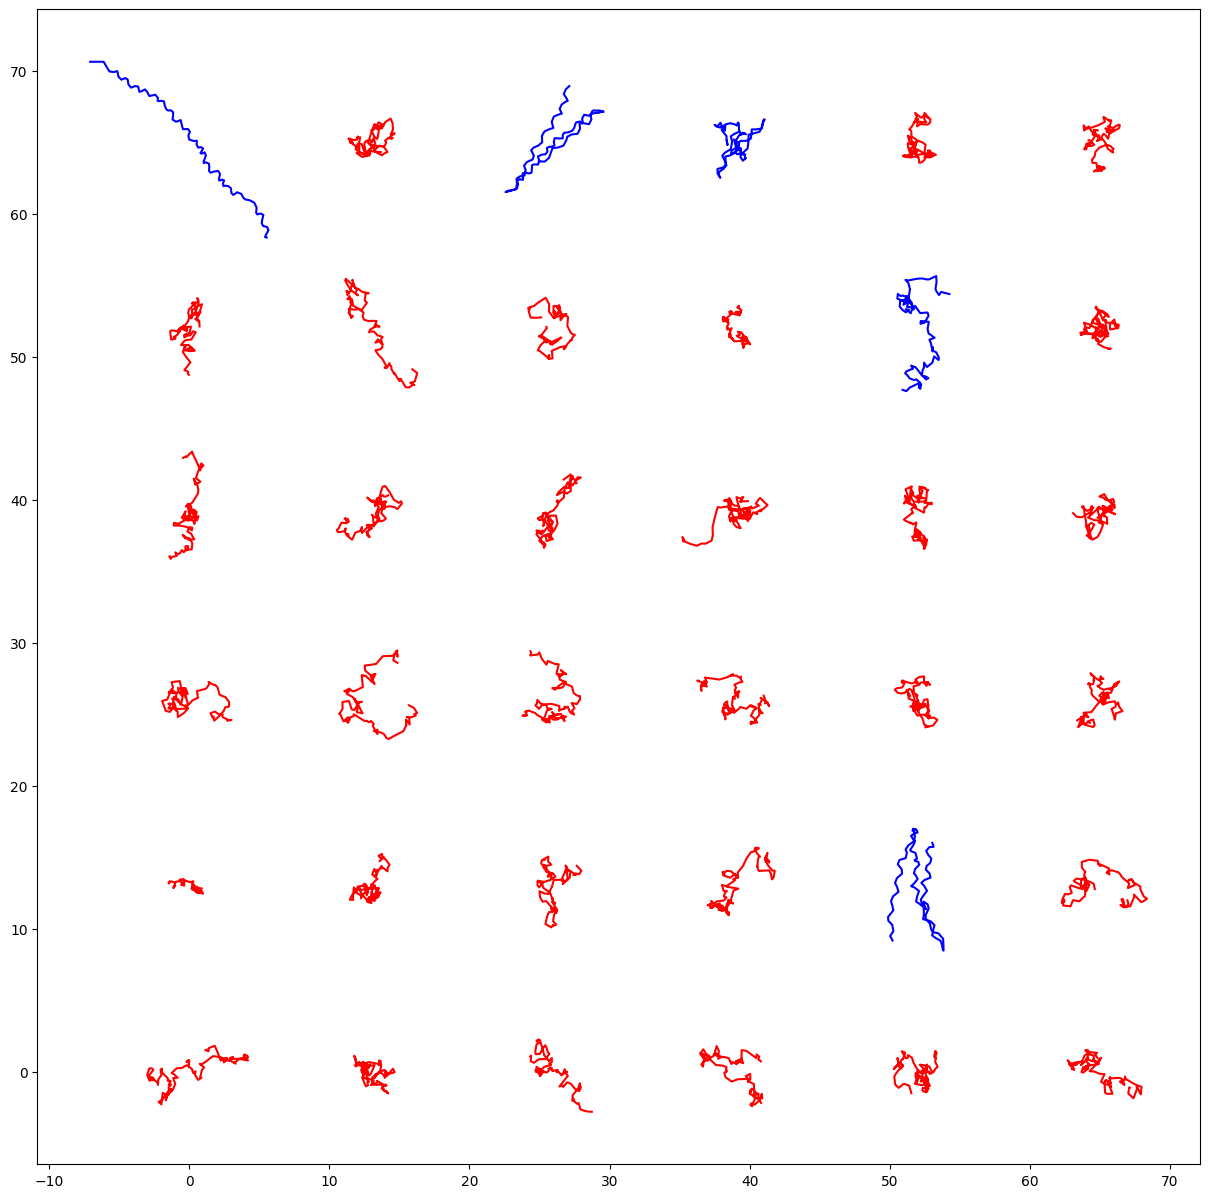

In [6]:

c = likelihood_ratio < 0.05 # array of booleans 
cs = ['r','b']
n = 6 # number of rows and columns to show in the plot

plt.figure(figsize = (15, 15))
lim = 13 # distance between tracks
for i in range(n):
    for j in range(n):
        track = tracks[i*n+j]
        track = track - np.mean(track,0, keepdims = True) + [[lim*i, lim*j]]
        plt.plot(track[:,0], track[:,1], alpha = 1, color = cs[c[i*n+j]*1])


Because we perform the test on many tracks and because a test using a threshold $k$ is expected to result in a faction $k$ of false positives, we must make sure that the fraction of significantly directed tracks is above that threshold.

In [11]:
p = 0.01
nb_success = np.sum(likelihood_ratio < p)
print('Fraction of significantly directed tracks: %s'%np.round(np.mean(likelihood_ratio < p), 5) + ', number of significantly directed tracks:', nb_success)

Fraction of significantly directed tracks: 0.09302, number of significantly directed tracks: 4


Here 9.3% is clearly higher than the threshold of 1%. To be more rigorous, we can perform a test on the number of tracks labeled as significantly directed. Under the null hypothesis, we expect the distribution of the number of tracks labeled as significantly directed to be a binomial distribution with $n$ trials and a success probability $p$. We can then comput the probability to have 4 significantly directed tracks with a threshold of 1% out of the 43 tracks.

In [12]:

n = len(tracks)
print('total number of tracks:', n)

import scipy
pvalue = 1-scipy.stats.binom.cdf(nb_success, n, p) # p-value = probability to have nb_success (here 4) or more significantly directed tracks out of n trials (here 43) with a probability of success per trial of p. 
print('p-value:', pvalue)


total number of tracks: 43
p-value: 7.01407919082575e-05


The p-value is below 5%. We can therefore reject the null hypothesis with a high degree of confidence. 

## Fitting a population of tracks to a model with multiple states of motion
This model assums that each particle is in one out of multiple states of motion. The states of motion considered by the model are either directed or confined. NB: the directed and confined models also include Brownian motion (if $l=0$).

When the number of tracks is low, CPU computing can be faster than GPU compluting. To force the use of the CPU when a GPU is available, one can use `with tf.device('/CPU:0'):` 

In [3]:

with tf.device('/CPU:0'):
    likelihoods, pd_params_multi = atrack.multi_fit(tracks, verbose = 0, Fixed_LocErr = False, min_nb_states = 1, max_nb_states = 8, nb_epochs = 1000, batch_size = 2**11,
               Initial_confined_params = {'LocErr': 0.02, 'd': 0.1, 'q': 0.01, 'l': 0.01},
               Initial_directed_params = {'LocErr': 0.02, 'd': 0.1, 'q': 0.01, 'l': 0.01},
               )


Number of estimated clusters : 8
reduction phase: phase where we test the clustered states and remove the states that do not significantly increase the likelihood. If no state is removed during this stage, increase the value of the parameter `initial_nb_states` (integer)


C:\Users\franc\anaconda3\envs\pyTF310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\franc\anaconda3\envs\pyTF310\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\franc\anaconda3\envs\pyTF310\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\franc\anaconda3\envs\pyTF310\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\franc\anaconda3\envs\pyTF310\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess

current number of states:  8
current number of states:  7 , likelihoods: 
                                                                     
number of states  1.0  2.0  3.0  4.0  5.0  6.0   7.000000   8.000000
Likelihood        0.0  0.0  0.0  0.0  0.0  0.0  18.358822  18.359493
current number of states:  7
current number of states:  6 , likelihoods: 
                                                                           
number of states  1.0  2.0  3.0  4.0  5.0   6.000000   7.000000   8.000000
Likelihood        0.0  0.0  0.0  0.0  0.0  18.359419  18.358822  18.359493
current number of states:  6
current number of states:  5 , likelihoods: 
                                                                        \
number of states  1.0  2.0  3.0  4.0   5.000000   6.000000   7.000000   
Likelihood        0.0  0.0  0.0  0.0  18.359528  18.359419  18.358822   

                             
number of states   8.000000  
Likelihood        18.359493  
current number of states:  5
curr

In [4]:
likelihoods.to_csv('likelihoods.csv')
for state in pd_params_multi.keys():
    pd_params_multi[state].to_csv('results_multi_%sstates.csv'%state)


We can then plot the likelihood depending on the number of states to select the best model. As mentionned in our article, the best number of states is when the likelihood plateaus. In this specific case, 4 to 5 states seem satisfying.

Text(0, 0.5, 'Likelihood')

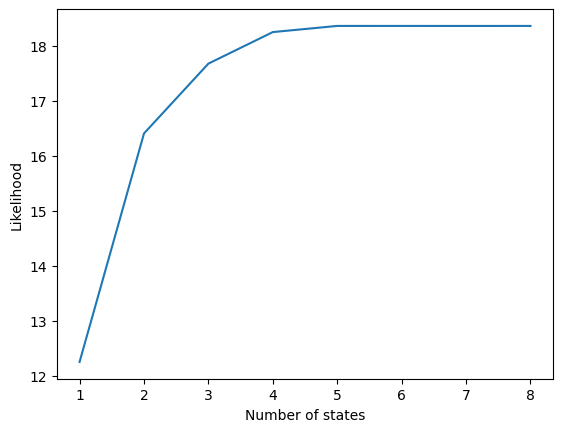

In [7]:
plt.figure()
plt.plot(likelihoods['number_of_states'], likelihoods['Likelihood'])
plt.xlabel('Number of states')
plt.ylabel('Likelihood')